In [1]:
import pandas as pd
import numpy as np
import joblib
from pandas_profiling import ProfileReport

In [2]:
import sys
sys.path.insert(0,'..')

from lib.feng_utils import calc_features

In [3]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,10)})

In [4]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [5]:
df_transactions = pd.read_csv("../data/input/2016-09-19_79351_training.csv")

In [6]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408546 entries, 0 to 408545
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   user_id                   408546 non-null  object 
 1   transaction_date          408546 non-null  object 
 2   transaction_type          408546 non-null  object 
 3   mcc_group                 258324 non-null  float64
 4   amount_internal_currency  408546 non-null  int64  
 5   dataset_transaction       408546 non-null  object 
 6   dataset_user              408546 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 21.8+ MB


In [7]:
profile = ProfileReport(df_transactions, title="Profiling Report")

In [8]:
profile.to_file("../doc/input_data_profile.html")

Summarize dataset:  50%|█████     | 10/20 [00:23<00:09,  1.00it/s, Calculate kendall correlation] /Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 177.24it/s]


In [9]:
ttype_direction_mapping = pd.read_csv("../data/input/transaction_types.csv")[["type", "direction"]].set_index("type")['direction'].to_dict()

In [10]:
ttypes = [*ttype_direction_mapping]

In [11]:
mcc_group_mapping = pd.read_csv("../data/input/mcc_group_definition.csv")[["mcc_group","explanation"]].set_index("mcc_group")['explanation'].to_dict()

In [12]:
mcc_groups = [*mcc_group_mapping]

In [13]:
joblib.dump((ttype_direction_mapping, mcc_group_mapping), "../data/model/ttype_mcc_group_mappings.pkl")

['../data/model/ttype_mcc_group_mappings.pkl']

In [14]:
df_transactions["direction"] = df_transactions["transaction_type"].apply(ttype_direction_mapping.get)

In [15]:
df_transactions['transaction_date'] = pd.to_datetime(df_transactions['transaction_date'])
df_transactions = df_transactions.sort_values('transaction_date', ascending=True)
df_transactions['month_year'] = df_transactions['transaction_date'].dt.to_period('M')

In [16]:
# extract a sample dataset to functionally test the requested prediction function
df_transactions[(df_transactions["user_id"].isin(np.random.choice(df_transactions['user_id'].unique(), 200))) & (df_transactions["month_year"] == "2016-07")].drop(columns=["month_year"]).to_csv("../tests/data/input/sample_transactions_data.csv")

In [17]:
df_transactions["in_flow"] = df_transactions.apply(lambda tx: tx.amount_internal_currency if tx.direction == 'In' else 0, axis=1)
df_transactions["out_flow"] = df_transactions.apply(lambda tx: tx.amount_internal_currency if tx.direction == 'Out' else 0, axis=1)

In [18]:
df_targets = df_transactions.groupby(['user_id', 'month_year']).agg({'in_flow': ['sum'], 'out_flow': ['sum']})

In [19]:
df_targets.columns = df_targets.columns.map('_'.join)

In [20]:
df_targets

in_flow_sum  out_flow_sum
user_id                          month_year                           
000295594379774ab9ac2c78c946d615 2016-02             291           280
                                 2016-03             381           391
                                 2016-05             155           154
                                 2016-06             115            68
                                 2016-07               0             9
...                                                  ...           ...
fffde1ba10b4040deb651162f56c9fc4 2016-03             213           345
                                 2016-04             229           268
                                 2016-05             647           374
                                 2016-06             239           217
                                 2016-07            1487          1571

[44214 rows x 2 columns]

In [21]:
# monthly inflow and outflow averages
df_monthly_target_means = df_targets.reset_index().groupby("month_year").agg({'in_flow_sum': ['mean'], 'out_flow_sum': ['mean']})
df_monthly_target_means.columns = df_monthly_target_means.columns.map('_'.join)
df_monthly_target_means

,in_flow_sum_mean,out_flow_sum_mean
month_year,,
2016-02,209.659015,224.216750
2016-03,228.790401,252.235816
2016-04,228.332478,261.817212
2016-05,229.947056,271.854403
2016-06,230.475128,271.134361
2016-07,232.481988,282.913868


In [22]:
df_monthly_target_means = pd.melt(df_monthly_target_means.reset_index(), ["month_year"])
df_monthly_target_means["month_year"] = df_monthly_target_means["month_year"].astype(str)

<AxesSubplot:xlabel='month_year', ylabel='value'>

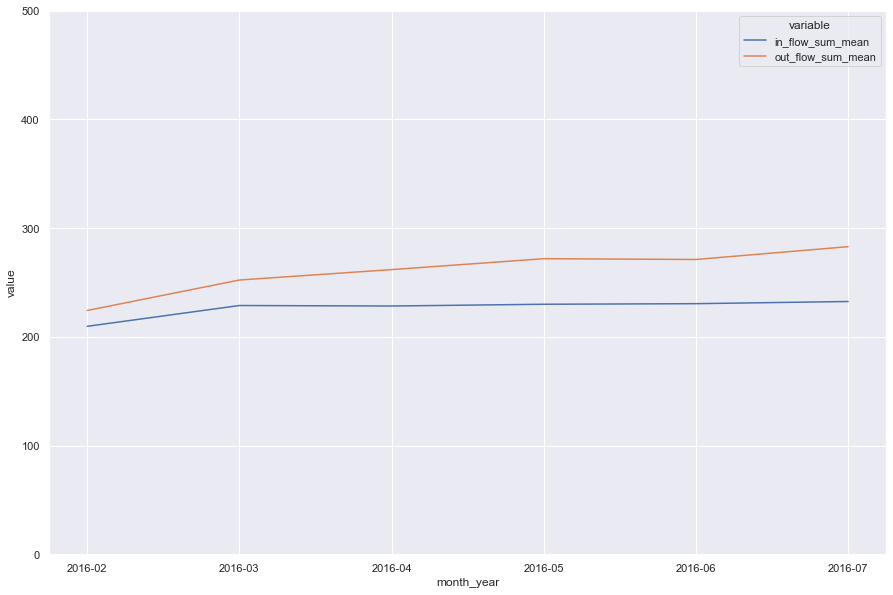

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,10))
ax.set(ylim=(0,500))
sns.lineplot(x="month_year", y='value', hue='variable', data=df_monthly_target_means, ax=ax)

In [24]:
# checking autocorrelation to check if there is a trend (only with lag=1 and lag=2 as the data range is very limited)
df_inflow_autocorr_lag1 = df_targets.reset_index().groupby("user_id").parallel_apply(lambda group: group['in_flow_sum'].autocorr(lag=1))
df_inflow_autocorr_lag2 = df_targets.reset_index().groupby("user_id").parallel_apply(lambda group: group['in_flow_sum'].autocorr(lag=2))

/Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divid

/Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divid

In [25]:
inflow_autocorr_df = pd.concat([df_inflow_autocorr_lag1.describe(), df_inflow_autocorr_lag2.describe()], axis=1).rename(columns={0: "inflow_autocorr_lag1", 1: "inflow_autocorr_lag2"})
inflow_autocorr_df

,inflow_autocorr_lag1,inflow_autocorr_lag2
count,7206.000000,6090.000000
mean,-0.219682,-0.102808
std,0.510309,0.638871
min,-1.000000,-1.000000
25%,-0.554819,-0.608486
50%,-0.302898,-0.235388
75%,0.072862,0.434558
max,1.000000,1.000000


In [26]:
df_outflow_autocorr_lag1 = df_targets.reset_index().groupby("user_id").parallel_apply(lambda group: group['out_flow_sum'].autocorr(lag=1))
df_outflow_autocorr_lag2 = df_targets.reset_index().groupby("user_id").parallel_apply(lambda group: group['out_flow_sum'].autocorr(lag=2))

/Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divid

/Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divid

In [27]:
outflow_autocorr_df = pd.concat([df_outflow_autocorr_lag1.describe(), df_outflow_autocorr_lag2.describe()], axis=1).rename(columns={0: "outflow_autocorr_lag1", 1: "outflow_autocorr_lag2"})
outflow_autocorr_df

,outflow_autocorr_lag1,outflow_autocorr_lag2
count,7796.000000,6819.000000
mean,-0.152741,-0.103722
std,0.552398,0.660334
min,-1.000000,-1.000000
25%,-0.548943,-0.662838
50%,-0.218536,-0.212550
75%,0.196152,0.462053
max,1.000000,1.000000


In [28]:
inflow_autocorr_df.join(outflow_autocorr_df)

,inflow_autocorr_lag1,inflow_autocorr_lag2,outflow_autocorr_lag1,outflow_autocorr_lag2
count,7206.000000,6090.000000,7796.000000,6819.000000
mean,-0.219682,-0.102808,-0.152741,-0.103722
std,0.510309,0.638871,0.552398,0.660334
min,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.554819,-0.608486,-0.548943,-0.662838
50%,-0.302898,-0.235388,-0.218536,-0.212550
75%,0.072862,0.434558,0.196152,0.462053
max,1.000000,1.000000,1.000000,1.000000


In [32]:
def calc_rel_std(vals):
    return np.std(vals) / np.mean(vals)

df_inflow_rstd = df_targets.reset_index().groupby("user_id").apply(lambda group: calc_rel_std(group["in_flow_sum"]))

/Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [31]:
df_outflow_rstd = df_targets.reset_index().groupby("user_id").apply(lambda group: calc_rel_std(group["out_flow_sum"]))

/Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [33]:
df_inflow_rstd.describe()

count    9138.000000
mean        0.858372
std         0.481884
min         0.000000
25%         0.551145
50%         0.838871
75%         1.113997
max         2.236068
dtype: float64

In [34]:
df_outflow_rstd.describe()

count    9687.000000
mean        0.657205
std         0.392126
min         0.000000
25%         0.386475
50%         0.639041
75%         0.915585
max         2.236068
dtype: float64

In [35]:
random_user_ids = np.random.choice(df_targets.reset_index()['user_id'].unique(), 50)

In [36]:
df_targets_flat = df_targets.reset_index()

In [37]:
df_targets_flat["month_year"] = df_targets_flat["month_year"].apply(lambda val: str(val).replace('-', ''))

In [38]:
df_targets_sample = df_targets_flat[df_targets_flat["user_id"].isin(random_user_ids)]

In [39]:
df_targets_sample

,user_id,month_year,in_flow_sum,out_flow_sum
441,02a91eb00c0ecc8dee37973babde8ec6,201602,0,138
442,02a91eb00c0ecc8dee37973babde8ec6,201603,0,4
443,02a91eb00c0ecc8dee37973babde8ec6,201606,74,0
444,02a91eb00c0ecc8dee37973babde8ec6,201607,92,126
1503,08b53464fec8d82e9c6bc43f68bc904a,201602,657,524
...,...,...,...,...
43880,fe407c4a6c03cafd34cd174927a30bbf,201603,0,118
43881,fe407c4a6c03cafd34cd174927a30bbf,201604,194,78
43882,fe407c4a6c03cafd34cd174927a30bbf,201605,194,36
43883,fe407c4a6c03cafd34cd174927a30bbf,201606,194,111


<AxesSubplot:xlabel='month_year', ylabel='in_flow_sum'>

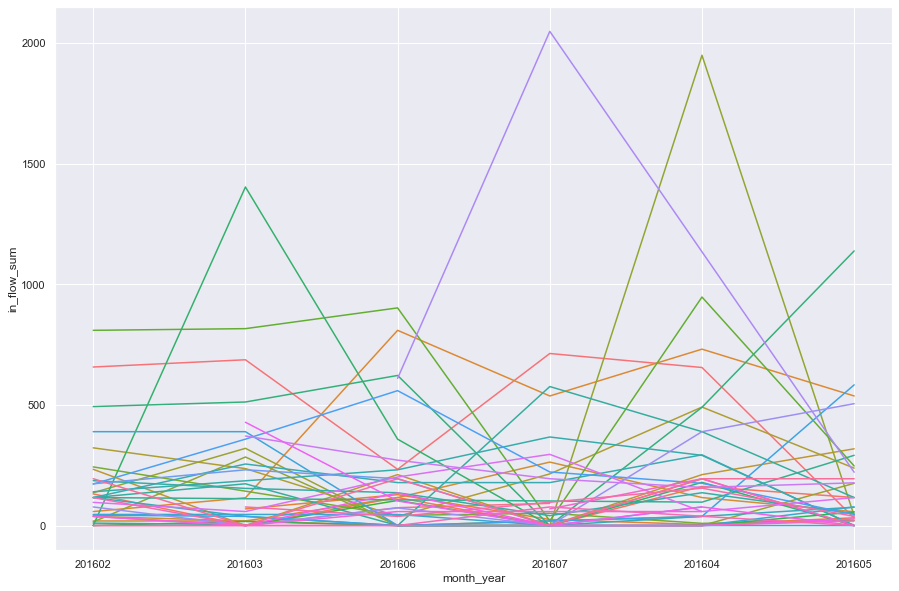

In [40]:
fig, ax = plt.subplots(figsize=(15,10))
sns.lineplot(data=df_targets_sample, x="month_year", y="in_flow_sum", hue='user_id', legend=False, ax=ax)

<AxesSubplot:xlabel='month_year', ylabel='out_flow_sum'>

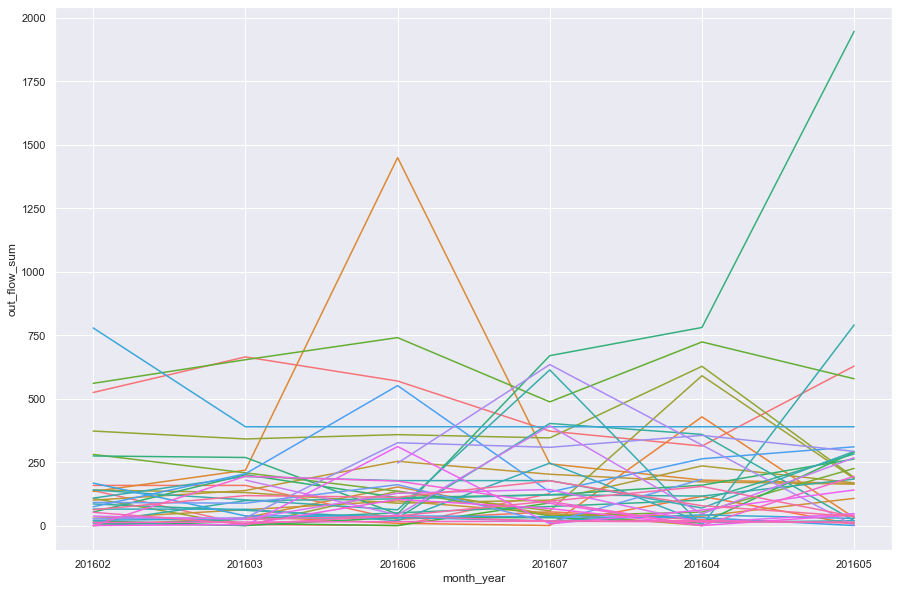

In [41]:
fig, ax = plt.subplots(figsize=(15,10))
sns.lineplot(data=df_targets_sample, x="month_year", y="out_flow_sum", hue='user_id', legend=False, ax=ax)

In [42]:
df_features = df_transactions.groupby(['user_id', 'month_year']).parallel_apply(lambda group: calc_features(group, ttypes, mcc_groups)).apply(pd.Series)

In [43]:
def calc_returning_customer_features(group):
    # could be better to use a window function that has a skewed triangle shape to weight the most recent observations more
    group['prev_monthly_in_flow_avg'] = group['in_flow_sum'].shift(1).rolling(5,1).mean()
    group['prev_monthly_out_flow_avg'] = group['out_flow_sum'].shift(1).rolling(5,1).mean()
    return group

In [44]:
df_features2 = df_targets.groupby('user_id').apply(calc_returning_customer_features).apply(pd.Series)

In [45]:
returning_user_lookup_table_df = df_targets.reset_index().groupby('user_id').agg({'in_flow_sum': ['mean'], 'out_flow_sum': ['mean']})
returning_user_lookup_table_df.columns = returning_user_lookup_table_df.columns.map('_'.join)
returning_user_lookup_table_df.rename(columns= {'in_flow_sum_mean': 'prev_monthly_in_flow_avg', 'out_flow_sum_mean': 'prev_monthly_out_flow_avg'}, inplace=True)
returning_user_lookup_table_df.to_csv("../data/model/returning_user_lookup_table_df.csv")

In [46]:
df_features2['is_new_customer'] = df_features2['prev_monthly_in_flow_avg'].isna()

In [47]:
df_train = df_features.join(df_features2)

In [48]:
df_train

ttype_PT_count  ttype_CT_count  \
user_id                          month_year                                   
000295594379774ab9ac2c78c946d615 2016-02                1.0             1.0   
                                 2016-03                3.0             1.0   
                                 2016-05                1.0             1.0   
                                 2016-06                6.0             0.0   
                                 2016-07                1.0             0.0   
...                                                     ...             ...   
fffde1ba10b4040deb651162f56c9fc4 2016-03               10.0             2.0   
                                 2016-04                9.0             2.0   
                                 2016-05               13.0             4.0   
                                 2016-06               12.0             2.0   
                                 2016-07               16.0             5.0   

                                             num_ttypes_seen  ttype_AR_count  \
user_id                          month_year                                    
000295594379774ab9ac2c78c946d615 2016-02                 2.0             0.0   
                                 2016-03                 3.0             0.0   
                                 2016-05                 3.0             0.0   
                                 2016-06                 2.0             0.0   
                                 2016-07                 1.0             0.0   
...                                                      ...             ...   
fffde1ba10b4040deb651162f56c9fc4 2016-03                 2.0             0.0   
                                 2016-04                 2.0             0.0   
                                 2016-05                 3.0             0.0   
                                 2016-06                 2.0             0.0   
                                 2016-07                 3.0             0.0   

                                             ttype_AE_count  ttype_AV_count  \
user_id                          month_year                                   
000295594379774ab9ac2c78c946d615 2016-02                0.0             0.0   
                                 2016-03                0.0             0.0   
                                 2016-05                0.0             0.0   
                                 2016-06                0.0             0.0   
                                 2016-07                0.0             0.0   
...                                                     ...             ...   
fffde1ba10b4040deb651162f56c9fc4 2016-03                0.0             0.0   
                                 2016-04                0.0             0.0   
                                 2016-05                0.0             0.0   
                                 2016-06                0.0             0.0   
                                 2016-07                0.0             0.0   

                                             ttype_BBU_count  ttype_DI_count  \
user_id                          month_year                                    
000295594379774ab9ac2c78c946d615 2016-02                 0.0             0.0   
                                 2016-03                 0.0             0.0   
                                 2016-05                 0.0             0.0   
                                 2016-06                 1.0             0.0   
                                 2016-07                 0.0             0.0   
...                                                      ...             ...   
fffde1ba10b4040deb651162f56c9fc4 2016-03                 0.0             0.0   
                                 2016-04                 0.0             0.0   
                                 2016-05                 0.0             0.0   
                                 2016-06                 0.0        

In [49]:
corr = df_train.corr()

In [50]:
mask = np.triu(np.ones_like(corr, dtype=bool))

In [51]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)

<AxesSubplot:>

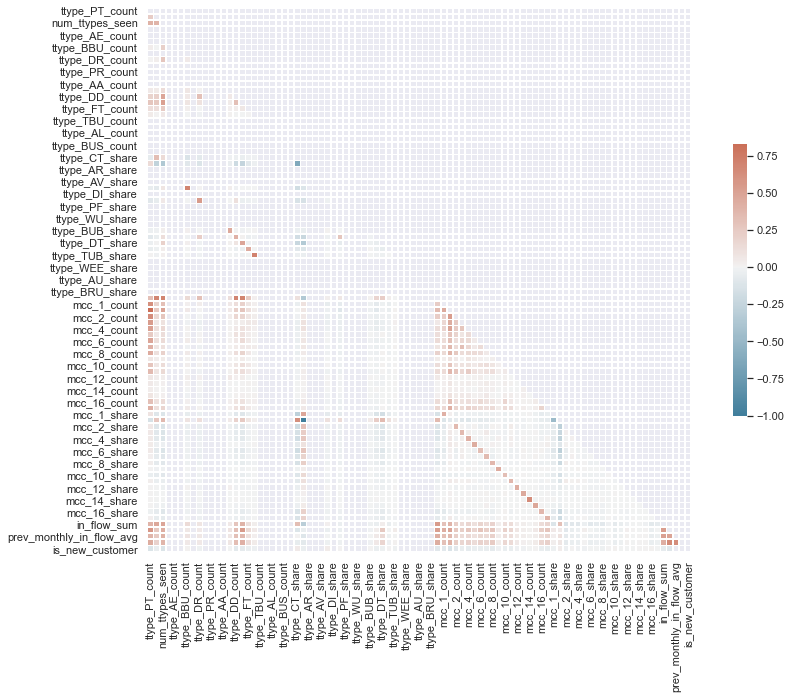

In [52]:
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Remove correlated columns

In [53]:
corr_abs = corr.abs()
upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(np.bool))
to_drop_candidate_groups = [[column] + list(upper[upper[column] > 0.90].index.values) for column in upper.columns if any(upper[column] > 0.90)]

/Users/anilpa/n26_task/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [54]:
to_drop_candidate_groups

[['mcc_nan_share', 'ttype_PT_share']]

In [55]:
to_drop = []

for to_drop_group in to_drop_candidate_groups:
    to_drop_candidates = [col for col in to_drop_group if col not in to_drop]
    if to_drop_candidates:
        keep_col = df_train[to_drop_candidates].apply(lambda col: abs(df_train['out_flow_sum'].corr(col)), axis=0).idxmax()
        to_drop.extend([col for col in to_drop_candidates if col != keep_col])

In [56]:
df_train.drop(to_drop, axis=1, inplace=True)

In [57]:
df_train.to_csv('../data/input/fenged_train.csv')